### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load the dataset 
used_cars = pd.read_csv("data/vehicles.csv")

### Exploratory Data Analysis (EDA)

In [4]:
used_cars.info()

used_cars.describe()

used_cars.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [5]:
used_cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [6]:
# Check for missing values
missing_values = used_cars.isnull().sum()
print(missing_values)

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


In [7]:
used_cars_data = used_cars.dropna()

In [8]:
# Check for missing values
missing_values = used_cars_data.isnull().sum()
print(missing_values)

id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
VIN             0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64


In [9]:
used_cars_data.describe()


,id,price,year,odometer
count,3.486800e+04,34868.000000,34868.000000,3.486800e+04
mean,7.311508e+09,15837.446771,2011.176867,1.073991e+05
std,4.299751e+06,13460.056823,7.162332,9.990878e+04
min,7.301592e+09,0.000000,1905.000000,0.000000e+00
25%,7.308189e+09,6500.000000,2008.000000,6.516400e+04
50%,7.312225e+09,12000.000000,2013.000000,1.040000e+05
75%,7.315136e+09,22003.500000,2016.000000,1.411678e+05
max,7.317099e+09,155000.000000,2022.000000,9.999999e+06


In [10]:

used_cars_data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al


In [11]:
used_cars_data = pd.get_dummies(used_cars_data, drop_first=True)
used_cars_data

,id,price,year,odometer,region_abilene,region_akron / canton,region_albany,region_albuquerque,region_altoona-johnstown,region_amarillo,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
126,7305672709,0,2018.0,68472.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
127,7305672266,0,2019.0,69125.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
128,7305672252,0,2018.0,66555.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
215,7316482063,4000,2002.0,155000.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
219,7316429417,2500,1995.0,110661.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426788,7303227528,12995,2016.0,61127.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
426792,7303114896,32999,2014.0,154642.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
426793,7303112347,15999,2018.0,36465.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
426833,7302338378,6800,1997.0,69550.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [12]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(used_cars_data.drop('price', axis=1))
used_cars_scaled = pd.DataFrame(scaled_features, columns=used_cars_data.columns.drop('price'))
used_cars_scaled['price'] = used_cars_data['price']
used_cars_scaled.tail()

,id,year,odometer,region_abilene,region_akron / canton,region_albany,region_albuquerque,region_altoona-johnstown,region_amarillo,region_ames,...,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,price
34863,-1.925795,0.673412,-0.463150,-0.016937,-0.059982,-0.099232,-0.070202,-0.017764,-0.028851,-0.023957,...,-0.161002,-0.205286,-0.067254,-0.171655,-0.14261,-0.095174,-0.182005,-0.050301,19.768037,NaN
34864,-1.951991,0.394170,0.472867,-0.016937,-0.059982,-0.099232,-0.070202,-0.017764,-0.028851,-0.023957,...,-0.161002,-0.205286,-0.067254,-0.171655,-0.14261,-0.095174,-0.182005,-0.050301,19.768037,NaN
34865,-1.952583,0.952655,-0.709999,-0.016937,-0.059982,-0.099232,-0.070202,-0.017764,-0.028851,-0.023957,...,-0.161002,-0.205286,-0.067254,-0.171655,-0.14261,-0.095174,-0.182005,-0.050301,19.768037,NaN
34866,-2.132589,-1.979393,-0.378842,-0.016937,-0.059982,-0.099232,-0.070202,-0.017764,-0.028851,-0.023957,...,-0.161002,-0.205286,-0.067254,-0.171655,-0.14261,-0.095174,-0.182005,-0.050301,19.768037,NaN
34867,-2.141220,0.952655,-0.869877,-0.016937,-0.059982,-0.099232,-0.070202,-0.017764,-0.028851,-0.023957,...,-0.161002,-0.205286,-0.067254,-0.171655,-0.14261,-0.095174,-0.182005,-0.050301,19.768037,NaN


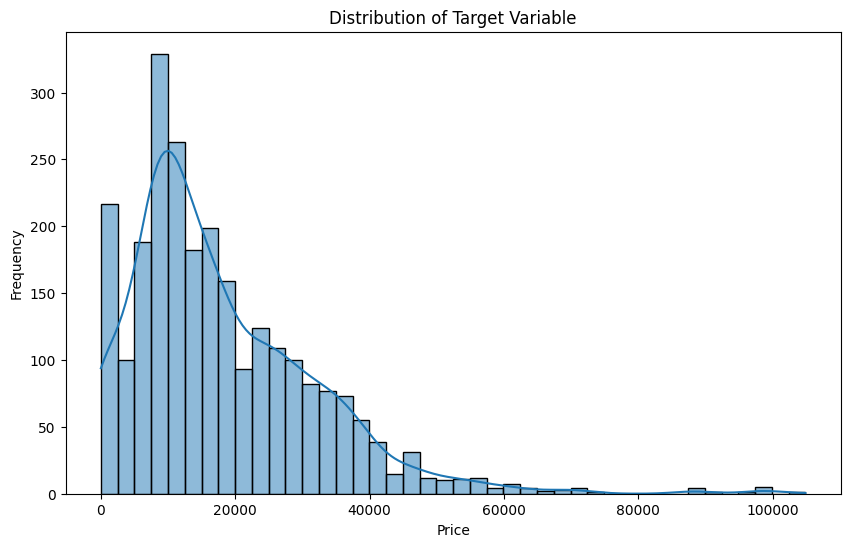

In [13]:
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(used_cars_scaled['price'], kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:

# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(used_cars_scaled.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Handle missing values (example: filling with mean)
#used_cars.fillna(used_cars.mean(), inplace=True)

In [ ]:
print (scaled_features)

In [ ]:

# Visualize relationships between features and target
sns.pairplot(used_cars_scaled, x_vars=scaled_features, y_vars='price', height=5, aspect=0.5)
plt.show()

# Splitting the data

In [ ]:
X = used_cars_scaled.drop('price', 